In [11]:
from MEDSAM_helper_functions import * # show_mask, show_box, medsam_inference

import sys, os
dir1 = os.path.abspath(os.path.join(os.path.abspath(''), '..', '..'))
if not dir1 in sys.path: sys.path.append(dir1)

from utils.environment import setup_data_vars

setup_data_vars()

## Get Example Slice For Inference

In [12]:
import SimpleITK as sitk

image_prefix = 'zzAMLART_'
nii_postfix = '_0000.nii.gz'
gt_postfix = '.nii.gz'

image_id = 10

img_class = 'Bladder' # 'CTVn'

image_path = os.path.join(os.environ.get('nnUNet_raw'), os.environ.get(img_class), os.environ.get('data_trainingImages'), image_prefix + str(image_id).zfill(3) + nii_postfix)
gt_path = os.path.join(os.environ.get('nnUNet_raw'), os.environ.get(img_class), os.environ.get('data_trainingLabels'), image_prefix + str(image_id).zfill(3) + gt_postfix)

gt_label = sitk.ReadImage(gt_path)
array_gt_label = sitk.GetArrayFromImage(gt_label)

image = sitk.ReadImage(image_path)
array_image = sitk.GetArrayFromImage(image)

# axis, img_slice = 0, 100
axis, img_slice = 1, 240
# axis, img_slice = 2, 240

slices = [slice(None)] * 3 # Create a list of slice(None) for all dimensions
slices[axis] = img_slice

# Extract 2D slice at axis
image_slice = array_image[tuple(slices)]
gt_slice = array_gt_label[tuple(slices)]

In [37]:
def visualise_pre_processing(array_image, array_gt_label):
    _, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(array_image, cmap='gray')
    axes[0].set_title('Raw Image')

    alpha_mask_gt = np.where(array_gt_label > 0, 1, 0).astype(np.float32)
    axes[1].imshow(array_image, cmap='gray')
    axes[1].imshow(array_gt_label, alpha=alpha_mask_gt, cmap='viridis')
    axes[1].set_title('Ground Truth')

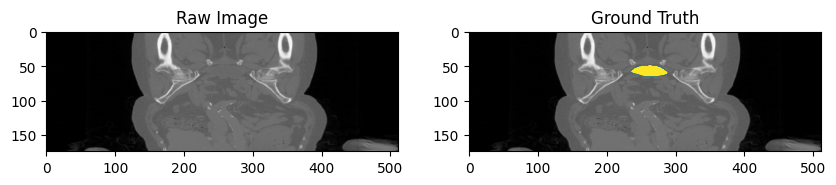

In [38]:
visualise_pre_processing(image_slice, gt_slice)

## Pre-processing Images

For CT images:
1. Normalized the Hounsfield units using typical window width and level values. The
employed window width and level values for soft tissues, lung, and brain are (W:400,
L:40), (W:1500, L:-160), and (W:80, L:40), respectively. 
2. The intensity values were rescaled to the range of [0, 255]. 
3. Finally, to meet the model’s input requirements, all images were resized to a uniform
size of 1024 × 1024 × 3. For 3D CT and MR images, each 2D slice was resized to 1024 ×
1024, and the channel was repeated three times to maintain consistency. 
4. Bi-cubic interpolation was used for
resizing images, while nearest-neighbor interpolation was applied for resizing masks to
preserve their precise boundaries and avoid introducing unwanted artifacts. 

### 1/2. Normalize Hounsfield units, Intesnity Values rescaled to [0, 255]

In [15]:
WINDOW_WIDTH = 400
WINDOW_LEVEL= 40

# Taken from pre_CT_MR.py
lower_bound = WINDOW_LEVEL - WINDOW_WIDTH / 2
upper_bound = WINDOW_LEVEL + WINDOW_WIDTH / 2
image_data_pre = np.clip(image_slice, lower_bound, upper_bound)
image_data_pre = (
    (image_data_pre - np.min(image_data_pre))
    / (np.max(image_data_pre) - np.min(image_data_pre))
    * 255.0
)

image_data_pre = np.uint8(image_data_pre)

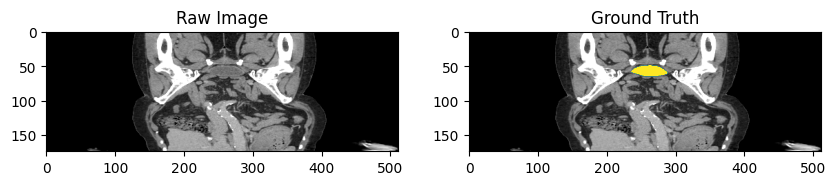

In [16]:
visualise_pre_processing(image_data_pre, gt_slice)

### 3. Resized to 1024 x 1024 x 3

In [39]:
image_size = 1024

img_3c = np.repeat(image_slice[:, :, None], 3, axis=-1)
resize_img_skimg = transform.resize(
    img_3c,
    (image_size, image_size),
    order=3,
    preserve_range=True,
    mode="constant",
    anti_aliasing=True,
)
resize_img_skimg_01 = (resize_img_skimg - resize_img_skimg.min()) / np.clip(
resize_img_skimg.max() - resize_img_skimg.min(), a_min=1e-8, a_max=None
)  # normalize to [0, 1], (H, W, 3)


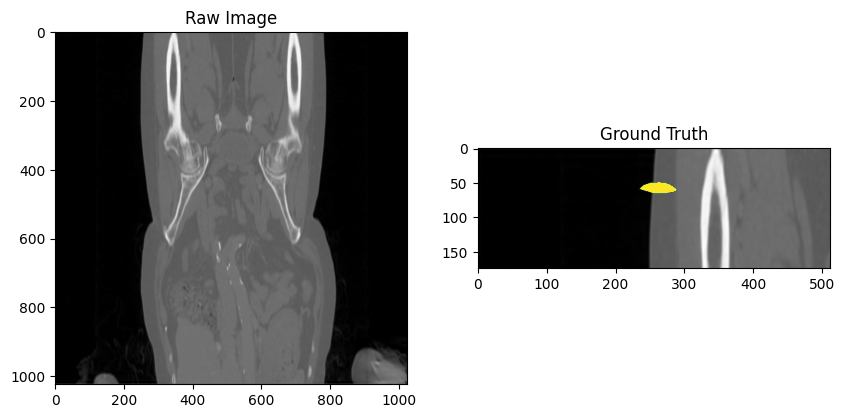

In [40]:
visualise_pre_processing(resize_img_skimg_01, gt_slice)

### 5. Same thing to GT, without the noramlization, only the size and interpolation

In [41]:
# remove small objects with less than 100 pixels in 2D slices

import cc3d

voxel_num_thre2d = 100

# remove small objects with less than 100 pixels
# reason: for such small objects, the main challenge is detection rather than segmentation
gt_slice = cc3d.dust(gt_slice, threshold=voxel_num_thre2d, connectivity=8, in_place=False)

resize_gt_skimg = transform.resize(
    gt_slice,
    (image_size, image_size),
    order=0,
    preserve_range=True,
    mode="constant",
    anti_aliasing=False,
)
resize_gt_skimg = np.uint8(resize_gt_skimg)

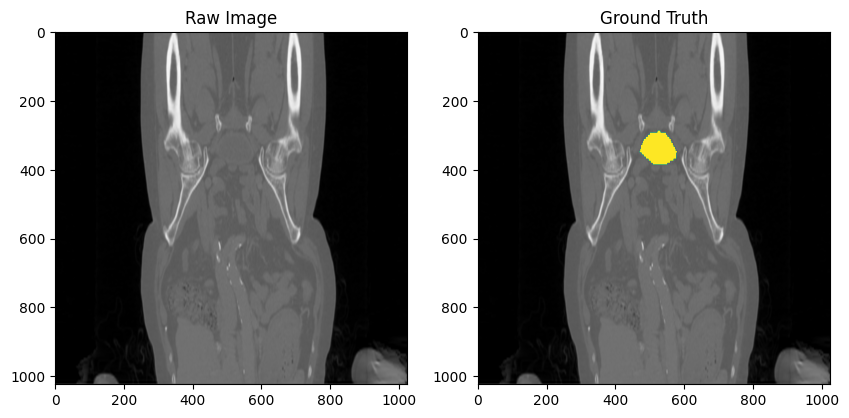

In [42]:
visualise_pre_processing(resize_img_skimg_01, resize_gt_skimg)

## Extract bounding box

In [61]:
import numpy as np

# Find non-zero elements in resize_gt_skimg
nonzero_indices = np.where(resize_gt_skimg != 0)

# Calculate bounding coordinates
x_min = np.min(nonzero_indices[1])
x_max = np.max(nonzero_indices[1])
y_min = np.min(nonzero_indices[0])
y_max = np.max(nonzero_indices[0])

box_np = np.array([[x_min, y_min, x_max, y_max]])

In [59]:
def visualise_bounding_box(array_image, array_gt_label, box):
    _, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(array_image, cmap='gray')
    axes[0].set_title('Raw Image')

    alpha_mask_gt = np.where(array_gt_label > 0, 1, 0).astype(np.float32)
    axes[1].imshow(array_image, cmap='gray')
    axes[1].imshow(array_gt_label, alpha=alpha_mask_gt, cmap='viridis')
    axes[1].set_title('Ground Truth')

    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    axes[2].imshow(array_image, cmap='gray')
    axes[2].add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="blue", facecolor=(0, 0, 0, 0), lw=2)
    )
    axes[2].set_title('Bounding Box From Ground Truth')

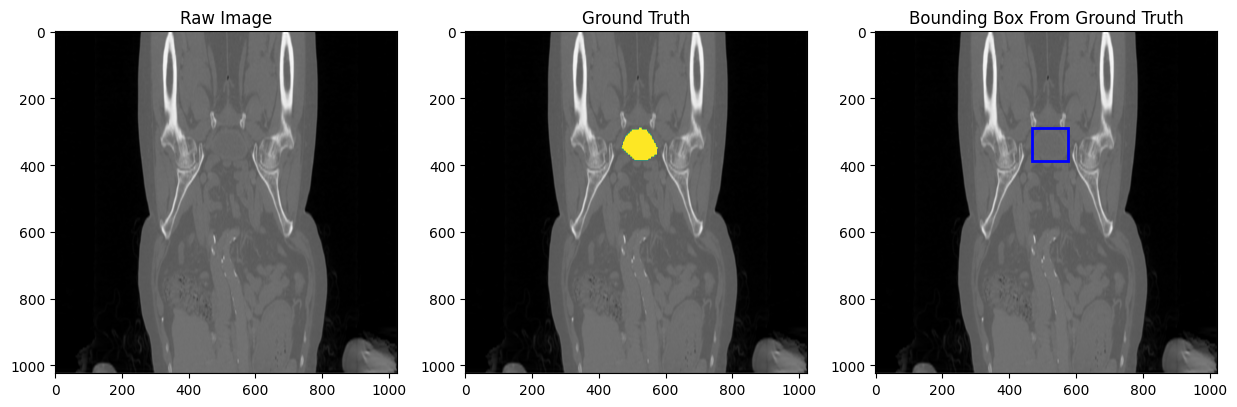

In [60]:
visualise_bounding_box(resize_img_skimg_01, resize_gt_skimg, box_np[0])

## Setup Model

In [67]:
MedSAM_CKPT_PATH = os.path.join(os.environ.get('PROJECT_DIR'),  "models/MedSAM/work_dir/MedSAM/medsam_vit_b.pth")

In [68]:
device = "cuda:0"
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device)
medsam_model.eval()
'medsam set to evaluation'

'medsam set to evaluation'

In [70]:
img_1024_tensor = torch.tensor(resize_img_skimg_01).float().permute(2, 0, 1).unsqueeze(0).to(device)

with torch.no_grad():
    image_embedding = medsam_model.image_encoder(img_1024_tensor) # (1, 256, 64, 64)

H, W, _ = resize_img_skimg_01.shape
medsam_seg = medsam_inference(medsam_model, image_embedding, box_np, H, W)

In [71]:
def visualise_bounding_box(array_image, array_gt_label, box, predicted_mask):
    _, axes = plt.subplots(1, 4, figsize=(15, 5))
    axes[0].imshow(array_image, cmap='gray')
    axes[0].set_title('Raw Image')

    alpha_mask_gt = np.where(array_gt_label > 0, 1, 0).astype(np.float32)
    axes[1].imshow(array_image, cmap='gray')
    axes[1].imshow(array_gt_label, alpha=alpha_mask_gt, cmap='viridis')
    axes[1].set_title('Ground Truth')

    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    axes[2].imshow(array_image, cmap='gray')
    axes[2].add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="blue", facecolor=(0, 0, 0, 0), lw=2)
    )
    axes[2].set_title('Bounding Box From Ground Truth')

    alpha_mask_pred = np.where(predicted_mask > 0, 1, 0).astype(np.float32)
    axes[3].imshow(array_image, cmap='gray')
    axes[3].imshow(predicted_mask, alpha=alpha_mask_pred, cmap='viridis')
    axes[3].set_title('Predicted Mask')

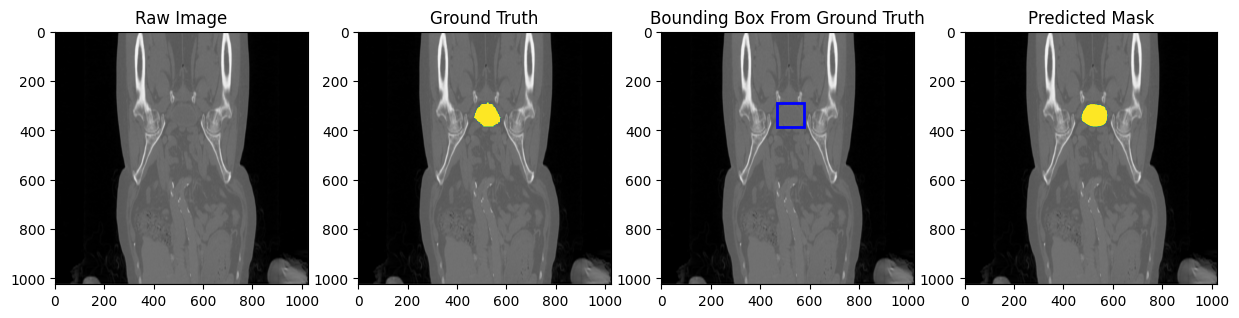

In [72]:
visualise_bounding_box(resize_img_skimg_01, resize_gt_skimg, box_np[0], medsam_seg)

In [76]:
import SimpleITK as sitk

def dice_similarity(gt, pred):
    overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()

    ypred_sitk = sitk.GetImageFromArray(pred)
    y_gt_sitk = sitk.GetImageFromArray(gt)

    overlap_measures_filter.Execute(y_gt_sitk, ypred_sitk)
    return overlap_measures_filter.GetDiceCoefficient()

dice_score = dice_similarity(resize_gt_skimg, medsam_seg)
print("Dice Similarity Score:", dice_score)

Dice Similarity Score: 0.9379972218714484
